In [ ]:
!pip install -q --upgrade keras-nlp tensorflow

In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import keras_nlp
import matplotlib.pyplot as plt
import time

rseed = 42

tf.random.set_seed(rseed)
np.random.seed(rseed)

#from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
twt_train = pd.read_csv('twitter_training.csv', header=None)
twt_train.columns = ["TweetID", "Topic", "Sentiment", "Message"]
twt_train["Message"] = twt_train["Message"].astype(str)
#twt_train = twt_train.drop_duplicates(subset=['TweetID'], keep='first')
twt_train, twt_valid = train_test_split(twt_train, test_size = 0.20, random_state=rseed)

twt_test = pd.read_csv('twitter_validation.csv', header=None)
twt_test.columns = ["TweetID", "Topic", "Sentiment", "Message"]
twt_test["Message"] = twt_test["Message"].astype(str)

twt_train

,TweetID,Topic,Sentiment,Message
8581,9472,Overwatch,Neutral,My goodness @ AmbarKOrtiz was SO mad at me for...
71534,11054,TomClancysGhostRecon,Positive,I must say that for every moment of fun I have...
67252,7116,johnson&johnson,Neutral,Business AwesomeCapital : Johnson & Meyer John...
41061,1446,Battlefield,Positive,Here it was! I found the Perfect Flamethrower ...
16591,9643,PlayStation5(PS5),Positive,It is not the first time that the EU Commissio...
...,...,...,...,...
37194,8379,Microsoft,Neutral,Microsoft opens up coronavirus threat data to ...
6265,278,Amazon,Neutral,"A fast-paced, riveting and unique read! Grab a..."
54886,2225,CallOfDuty,Negative,Nah fr find this shit a big warzone if you bee...
860,2552,Borderlands,Negative,borderlands 3 sucks why are yall giving money ...


In [ ]:
twt_train = twt_train[twt_train["Sentiment"] != "Irrelevant"]
twt_valid = twt_valid[twt_valid["Sentiment"] != "Irrelevant"]
twt_test = twt_test[twt_test["Sentiment"] != "Irrelevant"]

replace_map = {'Negative' : 0,
               'Positive' : 1,
               'Neutral' : 2}

twt_train.Sentiment = twt_train.Sentiment.map(replace_map)
twt_valid.Sentiment = twt_valid.Sentiment.map(replace_map)
twt_test.Sentiment = twt_test.Sentiment.map(replace_map)

print(len(twt_train))
print(len(twt_valid))
print(len(twt_test))
twt_train.Sentiment.value_counts()

49347
12345
828


<ipython-input-9-f53f5330a6bd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twt_train.Sentiment = twt_train.Sentiment.map(replace_map)


0    18023
1    16602
2    14722
Name: Sentiment, dtype: int64

In [ ]:
X_train = twt_train['Message']
y_train = twt_train['Sentiment']
X_valid = twt_valid['Message']
y_valid = twt_valid['Sentiment']
X_test = twt_test['Message']
y_test = twt_test['Sentiment']

X_trainB = twt_train['Message']
y_trainB = twt_train['Sentiment']
X_validB = twt_valid['Message']
y_validB = twt_valid['Sentiment']
X_testB = twt_test['Message']
y_testB = twt_test['Sentiment']

In [ ]:
def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    return text

X_train = X_train.apply(clean_text)
X_valid = X_valid.apply(clean_text)
X_test = X_test.apply(clean_text)

X_train

8581     my goodness   ambarkortiz was so mad at me for...
71534    i must say that for every moment of fun i have...
67252    business awesomecapital   johnson   meyer john...
41061    here it was  i found the perfect flamethrower ...
16591    it is not the first time that the eu commissio...
                               ...                        
37194    microsoft opens up coronavirus threat data to ...
6265     a fast paced  riveting and unique read  grab a...
54886    nah fr find this shit a big warzone if you bee...
860      borderlands   sucks why are yall giving money ...
15795    trump just banned eu travel for a month  is ma...
Name: Message, Length: 49347, dtype: object

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def remove_stop_words(text):
    results = []
    stop_words = stopwords.words('english')
    text = text.split()
    text = [results.append(word) for word in text if word not in stop_words]
    text = ' '.join(results)
    return text

X_train = X_train.apply(remove_stop_words)
X_valid = X_valid.apply(remove_stop_words)
X_test = X_test.apply(remove_stop_words)

X_train

8581     goodness ambarkortiz mad turning bag bastion l...
71534    must say every moment fun breakpoint serves le...
67252    business awesomecapital johnson meyer johnson ...
41061    found perfect flamethrower image scocontent sc...
16591                  first time eu commission taken step
                               ...                        
37194    microsoft opens coronavirus threat data public...
6265     fast paced riveting unique read grab copy murd...
54886    nah fr find shit big warzone beefing dont come...
860      borderlands sucks yall giving money random pit...
15795    trump banned eu travel month major still possi...
Name: Message, Length: 49347, dtype: object

In [ ]:
def lemmatize(text):
    text = text.split()
    text = [WordNetLemmatizer().lemmatize(w) for w in text]
    text = ' '.join(text)
    return text

X_train = X_train.apply(lemmatize)
X_valid = X_valid.apply(lemmatize)
X_test = X_test.apply(lemmatize)

X_train

8581     goodness ambarkortiz mad turning bag bastion l...
71534    must say every moment fun breakpoint serf leas...
67252    business awesomecapital johnson meyer johnson ...
41061    found perfect flamethrower image scocontent sc...
16591                  first time eu commission taken step
                               ...                        
37194    microsoft open coronavirus threat data public ...
6265     fast paced riveting unique read grab copy murd...
54886    nah fr find shit big warzone beefing dont come...
860      borderland suck yall giving money random pitch...
15795    trump banned eu travel month major still possi...
Name: Message, Length: 49347, dtype: object

In [ ]:
vocab_size = 10000

X_train = [keras.preprocessing.text.one_hot(d, vocab_size, split=' ') for d in X_train]
X_valid = [keras.preprocessing.text.one_hot(d, vocab_size, split=' ') for d in X_valid]
X_test = [keras.preprocessing.text.one_hot(d, vocab_size, split=' ') for d in X_test]

X_train
print(max(len(x) for x in X_train))
print(max(len(x) for x in X_valid))
print(max(len(x) for x in X_test))

130
163
47


In [ ]:
max_length = 163
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_length, padding='post')
X_valid = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=max_length, padding='post')
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_length, padding='post')

X_train

array([[1414, 4315, 8832, ...,    0,    0,    0],
       [2313, 7839, 7689, ...,    0,    0,    0],
       [2572, 2810, 4828, ...,    0,    0,    0],
       ...,
       [ 444, 8765, 6542, ...,    0,    0,    0],
       [3531, 9739,  265, ...,    0,    0,    0],
       [4361, 4823, 5092, ...,    0,    0,    0]], dtype=int32)

In [ ]:
model = keras.models.Sequential([
    #keras.layers.Hashing(num_bins=vocab_size, output_mode='one_hot'),
    keras.layers.Embedding(vocab_size, 8, input_length=max_length),

    keras.layers.Conv1D(128, 3),
    keras.layers.MaxPooling1D(),
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),

    keras.layers.Conv1D(256, 3),
    keras.layers.MaxPooling1D(),
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(.5),

    keras.layers.Conv1D(256, 3),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPooling1D(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(.5),

    keras.layers.Conv1D(128, 3),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPooling1D(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(.5),

    #keras.layers.Conv1D(64, 3),
    #keras.layers.LeakyReLU(),
    #keras.layers.MaxPooling1D(),
    #keras.layers.BatchNormalization(),
    #keras.layers.Dropout(.5),

    #keras.layers.Flatten(),
    #keras.layers.Dense(256),
    #keras.layers.LeakyReLU(),
    #keras.layers.Dropout(.5),

    keras.layers.Flatten(),
    keras.layers.Dense(128),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(.5),

    #keras.layers.Flatten(),
    keras.layers.Dense(64),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(.5),

    keras.layers.Dense(32),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(.5),

    keras.layers.Dense(3),
    keras.layers.Softmax()
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

start = time.time()
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid), callbacks = [callback])
end = time.time()

Epoch 1/10
1543/1543 [==============================] - 76s 37ms/step - loss: 1.1761 - accuracy: 0.3643 - val_loss: 1.1305 - val_accuracy: 0.4257
Epoch 2/10
1543/1543 [==============================] - 22s 14ms/step - loss: 0.9354 - accuracy: 0.5438 - val_loss: 0.8165 - val_accuracy: 0.5925
Epoch 3/10
1543/1543 [==============================] - 17s 11ms/step - loss: 0.7459 - accuracy: 0.6734 - val_loss: 0.6747 - val_accuracy: 0.7323
Epoch 4/10
1543/1543 [==============================] - 19s 12ms/step - loss: 0.5500 - accuracy: 0.7900 - val_loss: 0.6356 - val_accuracy: 0.7801
Epoch 5/10
1543/1543 [==============================] - 17s 11ms/step - loss: 0.4300 - accuracy: 0.8405 - val_loss: 0.5462 - val_accuracy: 0.8130
Epoch 6/10
1543/1543 [==============================] - 16s 11ms/step - loss: 0.3600 - accuracy: 0.8677 - val_loss: 0.5980 - val_accuracy: 0.8136
Epoch 7/10
1543/1543 [==============================] - 17s 11ms/step - loss: 0.3121 - accuracy: 0.8862 - val_loss: 0.5264 -

In [ ]:
duration = end-start
print(duration)

235.66637444496155


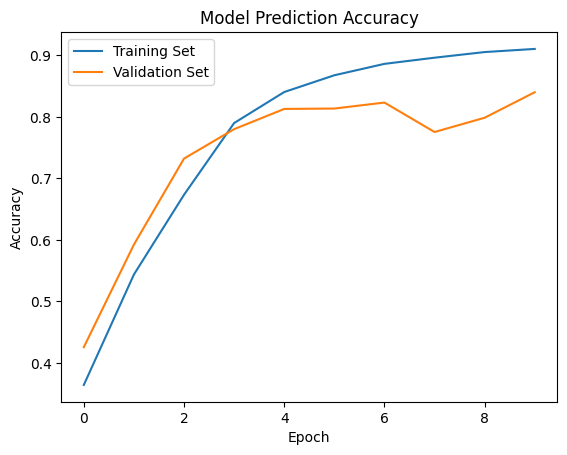

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Prediction Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper left')
plt.show()

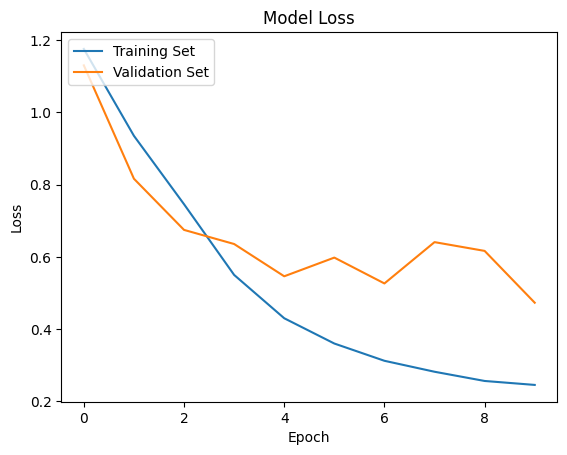

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper left')
plt.show()

In [ ]:
pred = np.argmax(model.predict(X_test),axis=1)

26/26 [==============================] - 0s 7ms/step


In [ ]:
y_test

1      2
2      0
3      0
4      2
5      0
      ..
993    0
994    1
997    1
998    1
999    2
Name: Sentiment, Length: 828, dtype: int64

In [ ]:
res = [1 if i==j else 0 for i, j in zip(pred,y_test)]
sum(res)/len(res)

0.9094202898550725

In [ ]:
bert = keras_nlp.models.BertClassifier.from_preset(
    "bert_tiny_en_uncased",
    num_classes=3,
)

callbackB = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=3)

17602216/17602216 [==============================] - 0s 0us/step


In [ ]:
start = time.time()
historyB = bert.fit(
    x=X_trainB,
    y=y_trainB,
    validation_data=(X_validB, y_validB),
    epochs=10,
    callbacks = [callbackB]
)
end = time.time()

Epoch 1/10
1543/1543 [==============================] - 564s 355ms/step - loss: 0.8301 - sparse_categorical_accuracy: 0.6344 - val_loss: 0.6887 - val_sparse_categorical_accuracy: 0.7155
Epoch 2/10
1543/1543 [==============================] - 532s 345ms/step - loss: 0.6088 - sparse_categorical_accuracy: 0.7541 - val_loss: 0.5397 - val_sparse_categorical_accuracy: 0.7864
Epoch 3/10
1543/1543 [==============================] - 581s 377ms/step - loss: 0.4607 - sparse_categorical_accuracy: 0.8213 - val_loss: 0.4286 - val_sparse_categorical_accuracy: 0.8356
Epoch 4/10
1543/1543 [==============================] - 587s 380ms/step - loss: 0.3588 - sparse_categorical_accuracy: 0.8621 - val_loss: 0.3771 - val_sparse_categorical_accuracy: 0.8565
Epoch 5/10
1543/1543 [==============================] - 587s 380ms/step - loss: 0.2990 - sparse_categorical_accuracy: 0.8834 - val_loss: 0.3329 - val_sparse_categorical_accuracy: 0.8768
Epoch 6/10
1543/1543 [==============================] - 582s 377ms/ste

In [ ]:
durationB = end-start
print(durationB)

5763.548139095306


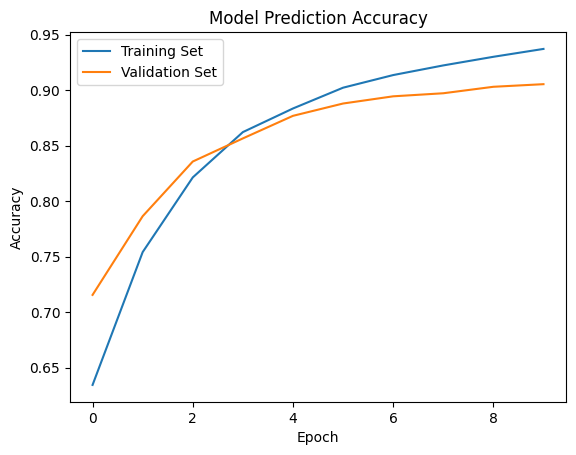

In [ ]:
plt.plot(historyB.history['sparse_categorical_accuracy'])
plt.plot(historyB.history['val_sparse_categorical_accuracy'])
plt.title('Model Prediction Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper left')
plt.show()

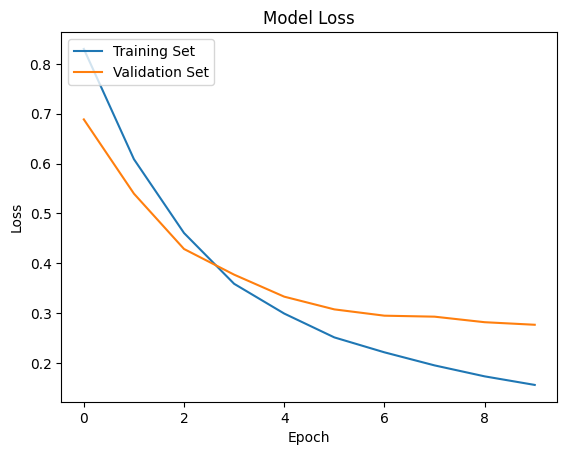

In [ ]:
plt.plot(historyB.history['loss'])
plt.plot(historyB.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper left')
plt.show()

In [ ]:
pred2 = np.argmax(bert.predict(X_testB),axis=1)

26/26 [==============================] - 5s 100ms/step


In [ ]:
res2 = [1 if i==j else 0 for i, j in zip(pred2,y_testB)]
sum(res2)/len(res2)

0.9541062801932367